In [ ]:
from PyParticle.population import build_population
import numpy as np 
#fixed_RI = [1.75, 0.44]
#fixed_RI = 1.75 + 0.44j
fixed_RI = 1.45 + 0.j
species_modifications = {'SO4':{'n_550': np.real(fixed_RI), 'k_550': np.imag(fixed_RI), 'alpha_n': 0.0, 'alpha_k': 0.0}}
pop_cfg_50nm = {
    "type": "binned_lognormals",
    "N": [1e7],
    #"N_units": "m-3",
    "GMD": [50e-9],
    #"GMD_units": "m",
    "GSD": [1.6],
    "aero_spec_names": [["SO4"]],
    "aero_spec_fracs": [[1.0]],
    "N_bins": 1000,
    "D_min": 1e-10,
    "D_max": 1e-2,
    #"refractive_index": fixed_RI,
    'species_modifications': species_modifications,#{'SO4':{'n_550': np.real(fixed_RI), 'k_550': np.imag(fixed_RI), 'alpha_n': 0.0, 'alpha_k': 0.0}},
  }
pop_cfg_100nm = pop_cfg_50nm.copy()
pop_cfg_100nm["GMD"] = [100e-9]

pop_cfg_200nm = pop_cfg_50nm.copy()
pop_cfg_200nm["GMD"] = [200e-9]

pop_configs = [pop_cfg_50nm, pop_cfg_100nm, pop_cfg_200nm]
pop_50nm = build_population(pop_cfg_50nm)
pop_100nm = build_population(pop_cfg_100nm)
pop_200nm = build_population(pop_cfg_200nm)




ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/fier887/miniforge3/envs/pyparticle-partmc/lib/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/fier887/miniforge3/envs/pyparticle-partmc/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/Users/fier887/miniforge3/envs/pyparticle-partmc/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/Users/fier887/miniforge3/envs/pyparticle-partmc/lib/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/Users/fier887/miniforge3/envs/pyparticle-partmc/lib/pytho

In [2]:

from PyParticle.viz.style import StyleManager, Theme
from PyParticle.viz.builder import build_plotter
mgr = StyleManager(Theme(), deterministic=True)

series = [
    {"key": "50", "population": pop_50nm, "label": "$\mu=50$ nm"},
    {"key": "100", "population": pop_100nm, "label": "$\mu=100$ nm"},
    {"key": "200", "population": pop_200nm, "label": "$\mu=200$ nm"},
]
line_styles = mgr.plan("line", [s["key"] for s in series])

import matplotlib.pyplot as plt


Replaced examples/helpers call with adapter at `PyParticle.adapters.pymiescatt_ref`; you can delete the old `helpers/pymiescatt_comparison` when ready.

/Users/fier887/Library/CloudStorage/OneDrive-PNNL/Code/PyParticle/src/PyParticle/aerosol_particle.py:262: UserWarning: Surface tension not implemented; returning default 0.072 N/m
  warnings.warn("Surface tension not implemented; returning default 0.072 N/m", UserWarning)


NameError: name 'pop_cfg' is not defined

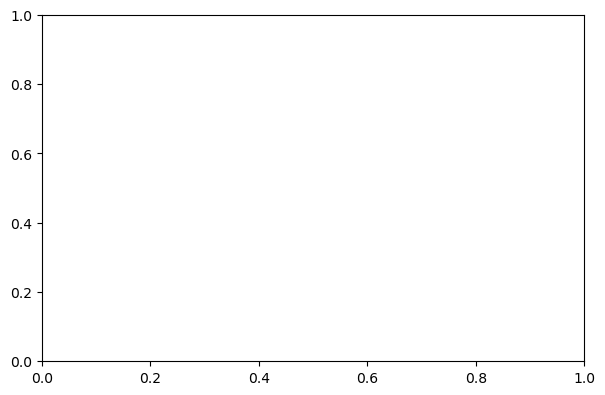

In [3]:
# Compare PyParticle b_scat against a PyMieScatt reference via the shared adapter
import numpy as np
import matplotlib.pyplot as plt

from PyParticle.population.builder import build_population
from PyParticle.analysis.population.factory import b_scat as _bscat

from PyParticle.adapters.pymiescatt_ref import pymiescatt_lognormal_optics  # returns (wvl_nm, b_scat_m, b_abs_m)

# # --- Resolve which series of populations to use ---
# resolved_series = []  # list of (label, pop_cfg_dict)
# if 'series' in globals() and series:
#     # Accept either tuples or dicts with keys {'label','population' or 'pop_cfg'}
#     for item in series:
#         if isinstance(item, tuple) and len(item) == 2:
#             label, pop_cfg = item
#             resolved_series.append((str(label), pop_cfg))
#         elif isinstance(item, dict):
#             label = item.get('label') or item.get('name') or 'series'
#             pop_cfg = item.get('pop_cfg') or item.get('population') or item.get('config')
#             if pop_cfg is not None:
#                 resolved_series.append((str(label), pop_cfg))

# # If nothing resolved yet, try common notebook vars (pop_cfg_50nm, pop_cfg_100nm, pop_cfg_200nm)
# if not resolved_series:
#     fallback = []
#     for label, varname in [("GMD=50 nm", 'pop_cfg_50nm'), ("GMD=100 nm", 'pop_cfg_100nm'), ("GMD=200 nm", 'pop_cfg_200nm')]:
#         if varname in globals():
#             fallback.append((label, globals()[varname]))
#     resolved_series = fallback

# if not resolved_series:
#     raise RuntimeError("No population configs found. Define `series` or variables like `pop_cfg_50nm` first.")

# # --- Grids (meters) ---
# wvl_grid = [450e-9, 550e-9, 650e-9]
wvl_grid = np.linspace(350e-9,1050e-9,8)
rh_grid  = [0.0]

fig, ax = plt.subplots(figsize=(7, 4.5))

for item in series:
#for label, pop_cfg in series:
    # Build population from config dict
    #pop = build_population(pop_cfg)
    pop = item['population']
    label = item['label']
    # PyParticle b_scat on the same grid as the adapter
    var_cfg = {
        "morphology": "homogeneous",
        "rh_grid": rh_grid,
        "wvl_grid": wvl_grid,
        "T": 298.15,
        "species_modifications": species_modifications,
    }
    b_pkg = np.asarray(_bscat.build(var_cfg).compute(pop), dtype=float).squeeze()

    # PyMieScatt reference via adapter
    # NOTE: adapter returns wavelengths in **nm** and coefficients in **m^-1**;
    #       we convert nm -> m for plotting with the same x-axis as the package line.
    wvl_nm, b_scat_ref, b_abs_ref = pymiescatt_lognormal_optics(pop_cfg, var_cfg)

    # Plot package
    ax.plot(wvl_grid, b_pkg, label=f"{label} — PyParticle", lw=2.0)
    # Plot reference (nm → m on x-axis)
    ax.plot(np.asarray(wvl_nm) * 1e-9, b_scat_ref, linestyle="--", linewidth=2.0,
            label=f"{label} — PyMieScatt (ref)")

ax.set_xlabel("Wavelength (m)")
ax.set_ylabel(r"$b_{scat}$ (m$^{-1}$)")
ax.set_title("Homogeneous spheres: PyParticle vs PyMieScatt")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9)
plt.show()

**New companion demo:** compare PyParticle core–shell optics vs a PyMieScatt-based reference via the shared adapter. Falls back to the tests adapter path if the packaged adapter isn’t installed yet.

In [ ]:
# Core–shell companion: PyParticle b_scat vs PyMieScatt reference
import numpy as np
import matplotlib.pyplot as plt

from PyParticle.population.builder import build_population
from PyParticle.analysis.population.factory import b_scat as _bscat

# Prefer packaged adapter; fall back to tests adapter during transition.
try:
    from PyParticle.adapters.pymiescatt_ref import pymiescatt_core_shell_optics  # (wvl_nm, b_scat_m, b_abs_m)
except Exception:
    from tests.integration.adapters.pymiescatt_ref import pymiescatt_core_shell_optics  # fallback path

# # --- Resolve population series exactly like the homogeneous cell ---
# resolved_series = []  # list of (label, pop_cfg_dict)
# if 'series' in globals() and series:
#     for item in series:
#         if isinstance(item, tuple) and len(item) == 2:
#             label, pop_cfg = item
#             resolved_series.append((str(label), pop_cfg))
#         elif isinstance(item, dict):
#             label = item.get('label') or item.get('name') or 'series'
#             pop_cfg = item.get('pop_cfg') or item.get('population') or item.get('config')
#             if pop_cfg is not None:
#                 resolved_series.append((str(label), pop_cfg))

# if not resolved_series:
#     fallback = []
#     for label, varname in [("GMD=50 nm", 'pop_cfg_50nm'), ("GMD=100 nm", 'pop_cfg_100nm'), ("GMD=200 nm", 'pop_cfg_200nm')]:
#         if varname in globals():
#             fallback.append((label, globals()[varname]))
#     resolved_series = fallback

# if not resolved_series:
#     raise RuntimeError("No population configs found. Define `series` or variables like `pop_cfg_50nm` first.")

# # --- Grids (meters) ---
# wvl_grid = [450e-9, 550e-9, 650e-9]
# rh_grid  = [0.0]

fig, ax = plt.subplots(figsize=(7, 4.5))

for item in series:
    pop = item['population']
    label = item['label']
    # PyParticle b_scat with core–shell morphology
    var_cfg = {
        "morphology": "core_shell",   # note underscore (factory name)
        "rh_grid": rh_grid,
        "wvl_grid": wvl_grid,
        "T": 298.15,
        "species_modifications": species_modifications,
    }
    b_pkg = np.asarray(_bscat.build(var_cfg).compute(pop), dtype=float).squeeze()

    # PyMieScatt reference via adapter
    # NOTE: adapter returns wavelengths in **nm** and coefficients in **m^-1**;
    #       convert nm -> m for plotting on the same x-axis.
    wvl_nm, b_scat_ref, b_abs_ref = pymiescatt_core_shell_optics(pop_cfg, var_cfg)

    # Plot package
    ax.plot(wvl_grid, b_pkg, label=f"{label} — PyParticle (core–shell)", lw=2.0)
    # Plot reference (nm → m on x-axis)
    ax.plot(np.asarray(wvl_nm) * 1e-9, b_scat_ref, '--', lw=2.0,
            label=f"{label} — PyMieScatt ref (core–shell)")

ax.set_xlabel("Wavelength (m)")
ax.set_ylabel(r"$b_{scat}$ (m$^{-1}$)")
ax.set_title("Core–shell particles: PyParticle vs PyMieScatt")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9)
plt.show()

# Tip: For a more physically meaningful core–shell demo, use a population that includes a BC core
# (e.g., species ['BC','SO4'] with a nonzero BC fraction); otherwise homogeneous and core–shell may be identical.